In [1]:
import pandas as pd # load and manipulate data and for One-Hot Encoding
import numpy as np # calculate the mean and standard deviation
import matplotlib.pyplot as plt # drawing graphs
from sklearn.tree import DecisionTreeClassifier # a classification tree
from sklearn.tree import plot_tree # draw a classification tree
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.model_selection import cross_val_score # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
dataset = pd.read_csv('Heart_Disease .csv')

In [4]:
dataset.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


<a id="identify-and-deal-with-missing-data"></a>
# Step 3: Missing Data Part 1: Identifying Missing Data
Unfortunately, the biggest part of any data analysis project is making sure that the data is correctly formatted and fixing it when it is not. The first part of this process is dealing with **Missing Data**.

**Missing Data** is simply a blank space or surrogate value that indicates that we failed to collect data for one of the features. For example, if we forgot to ask someone's age, or forgot to write it down, then we would have a blank space in the dataset for that person's **age**.

There are two main ways to deal with missing data:
1. We can remove the rows that contain missing data from the dataset. This is relatively easy to do, but it wastes all of the other values that we collected. How a big of a waste this is depends on how important this missing value is for classification. For example, if we are missing a value for **age**, and **age** is not useful for classifying if people have heart disease or not, then it would be a shame to throw out all of someone's data just because we do not have their **age**.
2. We can **impute** the values that are missing. In this context **impute** is just a fancy way of saying "we can make an educated guess about about what the value should be". Continuing our example where we are missing a value for **age**, instead of throwing out the entire row of data, we can fill the missing value with the average age or the median age, or use some other, more sophisticated approach, to guess at an appropriate value.

In this section, we'll focus on identifying missing values in the dataset and dealing with them.

First, let's see what sort of data is in each column.

In [5]:
dataset.dtypes

age          int64
sex          int64
cp           int64
restbp       int64
chol         int64
fbs          int64
restecg      int64
thalach      int64
exang        int64
oldpeak    float64
slope        int64
ca          object
thal        object
hd           int64
dtype: object

We see that that they are almost all `float64`, however, two columns, **ca** and **thal**, have the `object` type and one column, **hd** has `int64`.

The fact that the **ca** and **thal** columns have `object` data types suggests there is something funny going on in them. `object` datatypes are used when there are mixtures of things, like a mixture of numbers and letters. In theory, both **ca** and **thal** should just have a few values representing different categories, so let's investigate what's going on by printing out their unique values. We'll start with **ca**:

In [6]:
dataset['ca'].unique()

array(['0', '3', '2', '1', '?'], dtype=object)

We see that **ca** contains numbers (0.0, 3.0, 2.0 and 1.0) and questions marks (?). The numbers represent the number of blood vessels that we lit up by fluoroscopy and the question marks represent missing data.

Now let's look at the unique values in **thal**.

In [7]:
dataset['thal'].unique()

array(['6', '3', '7', '?'], dtype=object)

Again, **thal** also contains a mixture of numbers, representing the different diagnoses from the thalium heart scan, and question marks, which represent missing values.

----

# Step 4: Missing Data Part 2: Dealing With Missing Data

Since scikit-learn's classification trees do not support datasets with missing values, we need to figure out what to do these question marks. We can either delete these patients from the training dataset, or impute values for the missing data. First let's see how many rows contain missing values.

In [8]:
len(dataset.loc[(dataset['ca'] == '?')
                |
                (dataset['thal'] == '?')])


6

Since only 6 rows have missing values, let's look at them.

In [9]:
dataset.loc[(dataset['ca'] == '?')
                |
                (dataset['thal'] == '?')]


,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53,0,3,128,216,0,2,115,0,0.0,1,0,?,0
166,52,1,3,138,223,0,0,169,0,0.0,1,?,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,?,7,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0,?,1
287,58,1,2,125,220,0,0,144,0,0.4,2,?,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


Now let's count the number of rows in the full dataset.

In [10]:
len(dataset)

303

So 6 of the **303** rows, or **2%**, contain missing values. Since **303 - 6 = 297**, and **297** is plenty of data to build a classification tree, we will remove the rows with missing values, rather than try to impute their values. We do this by selecting all of the rows that do not contain question marks in either the **ca** or **thal** columns:

In [11]:
df_no_missing = dataset.loc[(dataset['ca'] != '?')
                &
                (dataset['thal'] != '?')]

Since `df_no_missing` has **6** fewer rows than the original `df`, it should have **297** rows.

In [12]:
len(df_no_missing)

297

The math works out. However, we can also make sure **ca** no longer contains question marks by printing its unique values:

In [13]:
df_no_missing['ca'].unique()

array(['0', '3', '2', '1'], dtype=object)

And we can also do the same thing for **thal**:

In [14]:
df_no_missing['thal'].unique()

array(['6', '3', '7'], dtype=object)

We have verified that `df_no_missing` does not contain any missing values. **NOTE:** **ca** and **thal** still have the `object` data type. That's OK. Now we are ready to format the data for making a **Classification Tree**.

----

<a id="format-the-data"></a>
# Step 5: Format Data Part 1: Split the Data into Dependent and Independent Variables

Now that we have taken care of the missing data, we are ready to start formatting the data for making a **Classification Tree**.

The first step is to split the data into two parts:
1. The columns of data that we will use to make classifications
2. The column of data that we want to predict.

We will use the conventional notation of `X` (capital **X**) to represent the columns of data that we will use to make classifications and `y` (lower case **y**) to represent the thing we want to predict. In this case, we want to predict **hd** (heart disease).

The reason we deal with missing data before splitting it into **X** and **y** is that if we remove rows, splitting after ensures that each row in **X** correctly corresponds with the appropriate value in **y**.

**NOTE:** In the code below we are using `copy()` to copy the data *by value*. By default, pandas uses copy *by reference*. Using `copy()` ensures that the original data `df_no_missing` is not modified when we modify `X` or `y`. In other words, if we make a mistake when we are formatting the columns for classification trees, we can just re-copy `df_no_missing`, rather than have to reload the original data and  remove the missing values etc.

In [15]:
X = df_no_missing.drop('hd', axis=1).copy()
X.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3


In [16]:
y = df_no_missing['hd'].copy()
y.head()

0    0
1    1
2    1
3    0
4    0
Name: hd, dtype: int64

----

<a id="one-hot-encoding"></a>
# Step 6: Format the Data Part 2: One-Hot Encoding



In [17]:
X.dtypes

age          int64
sex          int64
cp           int64
restbp       int64
chol         int64
fbs          int64
restecg      int64
thalach      int64
exang        int64
oldpeak    float64
slope        int64
ca          object
thal        object
dtype: object

In [18]:
X['cp'].unique()

array([1, 4, 3, 2])

So, the good news is that **cp** only contains the values it is supposed to contain, so we will convert it, using **One-Hot Encoding**, into a series of columns that only contains **0s** and **1s**.

In [19]:
pd.get_dummies(X , columns=['cp']).head()

,age,sex,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,cp_1,cp_2,cp_3,cp_4
0,63,1,145,233,1,2,150,0,2.3,3,0,6,1,0,0,0
1,67,1,160,286,0,2,108,1,1.5,2,3,3,0,0,0,1
2,67,1,120,229,0,2,129,1,2.6,2,2,7,0,0,0,1
3,37,1,130,250,0,0,187,0,3.5,3,0,3,0,0,1,0
4,41,0,130,204,0,2,172,0,1.4,1,0,3,0,1,0,0


As we can see in the printout above, `get_dummies()` puts all of the columns it does not process in the front and it puts **cp** at the end. It also split **cp** into **4** columns, just like we expected it. **cp_1.0** is `1` for any patient that scored a **1** for chest pain and `0` for all other patients. **cp_2.0** is `1` for any patient that scored **2** for chest pain and `0` for all other patients. **cp_3.0** is `1` for any patient that scored **3** for chest pain and **cp_4.0** is `1` for any patient that scored **4** for chest pain.

Now that we see how `get_dummies()` works, let's use it on the four categorical columns that have more than 2 categories and save the result.

**NOTE:** In practice you should verify all 5 of these columns to make sure they only contain
the accepted categories.

In [20]:
X_encoded = pd.get_dummies(X , columns=[ 'cp' , 'restecg', 'slope', 'thal' , 'oldpeak'])
X_encoded.head()

,age,sex,restbp,chol,fbs,thalach,exang,ca,cp_1,cp_2,...,oldpeak_3.2,oldpeak_3.4,oldpeak_3.5,oldpeak_3.6,oldpeak_3.8,oldpeak_4.0,oldpeak_4.2,oldpeak_4.4,oldpeak_5.6,oldpeak_6.2
0,63,1,145,233,1,150,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,67,1,160,286,0,108,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,67,1,120,229,0,129,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,37,1,130,250,0,187,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,41,0,130,204,0,172,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Now we need to talk about the **3** categorical columns that only contain **0**s and **1**s: **sex**, **fbs** (fasting blood sugar), and **exang** (exercise induced angina). As we can see, **One-Hot Encoding** converts a column with more than **2** categories, like **cp** (chest pain) into multiple columns of **0**s and **1**s. Since **sex**, **fbs**, and **exang** only have **2** categories and only contain **0**s and **1**s to begin with, we do not have to do anything special to them, so we're done formatting the data for the **Classification Tree**.

**NOTE:** In practice we would use `unique()` to verify that they only contain **0**s and **1**s.

Now, one last thing before we build a Classification Tree.  `y` doesn't just contain **0**s and **1**s. Instead, it has **5** different levels of heart disease. **0 =** no heart disease and **1-4** are various degrees of heart disease. We can see this with `unique()`:

In [21]:
y.unique()

array([0, 1])

Since we're only making a tree that does simple classification and only care if someone has heart disease or not, we need to convert all numbers **> 0** to **1**.

In [22]:
y_not_zero_index = y>0
y[y_not_zero_index] = 1
y.unique()

array([0, 1])

We have finally finished formatting the data for making a **Classification Tree**, so let's do it!!!


<a id="build-tree"></a>
# Step 7 : Build A Preliminary Classification Tree
At long last, the data is correctly formatted for making a **Classification Tree**. Now we simply split the data into **training** and **testing** sets and build the tree.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
clf_dt = DecisionTreeClassifier(random_state=42)
print(clf_dt)
clf_dt = clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)


OK, we've built a **Classification Tree** for classification. Let's see how it performs on the **Testing Dataset** by running the **Testing Dataset** down the tree and drawing a **Confusion Matrix**.

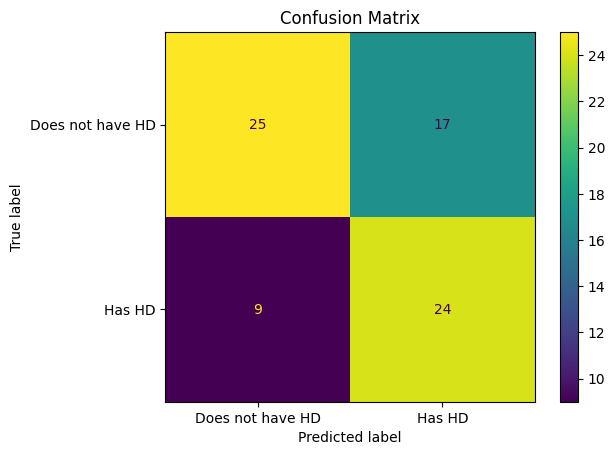

[Text(0.5879629629629629, 0.9615384615384616, 'ca <= 0.5\ngini = 0.498\nsamples = 222\nvalue = [118, 104]\nclass = No HD'),
 Text(0.36574074074074076, 0.8846153846153846, 'thal <= 6.5\ngini = 0.382\nsamples = 132\nvalue = [98, 34]\nclass = No HD'),
 Text(0.2361111111111111, 0.8076923076923077, 'oldpeak <= 2.7\ngini = 0.24\nsamples = 93\nvalue = [80, 13]\nclass = No HD'),
 Text(0.1574074074074074, 0.7307692307692307, 'age <= 58.5\ngini = 0.185\nsamples = 87\nvalue = [78, 9]\nclass = No HD'),
 Text(0.09259259259259259, 0.6538461538461539, 'chol <= 311.5\ngini = 0.061\nsamples = 63\nvalue = [61, 2]\nclass = No HD'),
 Text(0.05555555555555555, 0.5769230769230769, 'restbp <= 109.0\ngini = 0.033\nsamples = 60\nvalue = [59, 1]\nclass = No HD'),
 Text(0.037037037037037035, 0.5, 'sex <= 0.5\ngini = 0.278\nsamples = 6\nvalue = [5, 1]\nclass = No HD'),
 Text(0.018518518518518517, 0.4230769230769231, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]\nclass = No HD'),
 Text(0.05555555555555555, 0.4230769230

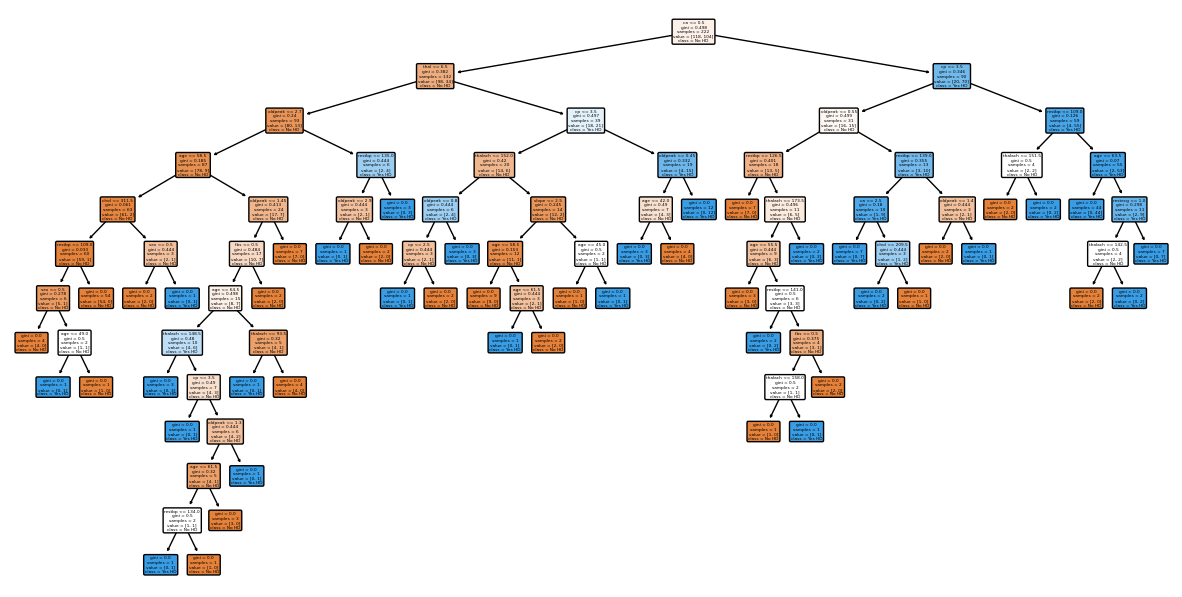

In [35]:
clf_dt = DecisionTreeClassifier(criterion='gini', random_state=42)
clf_dt.fit(X_train, y_train)

# Predictions for updated confusion matrix plot
y_pred_updated = clf_dt.predict(X_test)

# Generating Confusion Matrix
cm_updated = confusion_matrix(y_test, y_pred_updated)

# Using ConfusionMatrixDisplay with updated request
disp_updated = ConfusionMatrixDisplay(confusion_matrix=cm_updated, display_labels=["Does not have HD", "Has HD"])
disp_updated.plot()
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(15,7.5))
plot_tree(clf_dt,
          filled=True,
          rounded=True,
          class_names=["No HD", "Yes HD"],
          feature_names=X.columns)

In the confusion matrix, we see that of the **25 + 17 = 42** people that did not have **Heart Disease**, **25 (59%)** were correctly classified. And of the **9 + 24 = 33** people that have **Heart Disease**, **24 (73%)** were correctly classified. Can we do better? One thing that might be holding this **Classification Tree** back is that it may have **over fit** the training dataset. So let's prune the tree. Pruning, in theory, should solve the over fitting problem and give us better results.

----

<a id="prune-tree"></a>
# Step 8: Cost Complexity Pruning Part 1: Visualize alpha

**Decision Trees** are notorious for being **overfit** to the **Training Dataset**, so let's prune this tree in hopes that we can improve the accuracy with the **Testing Dataset**.

Pruning a decision tree is all about finding the right value for the pruning parameter, `alpha`, which controls how little or how much pruning happens. One way to find the optimal value for `alpha` is to plot the accuracy of the tree as a function of different values for `alpha`.  We'll do this for both the **Training Dataset** and the **Testing Dataset**.

First, let's extract the different values of `alpha` that are available for this tree and build a pruned tree for each value for `alpha`. **NOTE:** We omit the maximum value for alpha because it would prune all leaves, leaving us with only a root instead of a tree, with the following: `ccp_alphas = ccp_alphas[:-1]`.

In [25]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
ccp_alphas = ccp_alphas[:-1]

clf_dts = []
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
#     print(clf_dt)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

Now let's graph the accuracy of the trees using the **Training Dataset** and the **Testing Dataset** as a function of alpha.

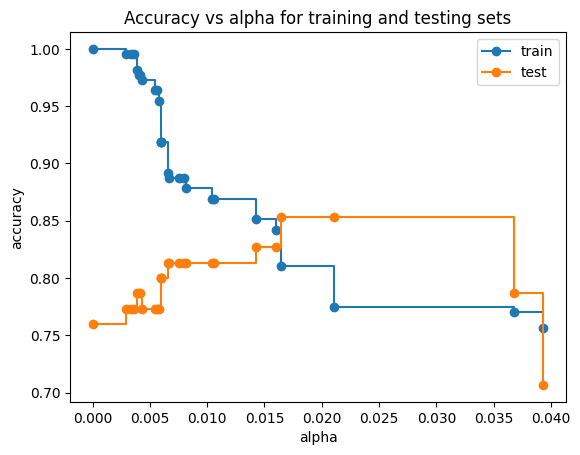

In [26]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In the graph above, we see that the accuracy for the **Testing Dataset** hits its maximum value when `alpha` is about **0.016**. After this value for `alpha`, the accuracy of the **Training Dataset** drops off and that suggest we should set `ccp_alpha=0.016`.

However, since there are many ways we could have divided the original dataset into **Training** and **Testing** datasets, how do we know we used the best **Training Dataset** and how do we know we used the best **Testing Dataset**? Typically, we answer this question with **10-Fold Cross Validation**. So that's what we're going to do now, and we'll do it with the `cross_val_score()` function.

----

# Step 9: Cost Complexity Pruning Part 2: Cross Validation For Finding the Best Alpha

The graphs we just drew suggest one value for alpha, **0.016**, but another
set of data might suggest another optimal value.

<!-- **Terminology Alert!!!** Since, ultimately, we have to decide on one value for `alpha`, and
the **Decision Tree** algorithm will not do this for us, `alpha` is called a **Hyperparameter** to differentiate it from the parameters that the **Decision Tree** algorithm can take care of on its own. -->

First, let's demonstrate that different training and testing datasets result in trees with different accuracies:

<Axes: xlabel='tree'>

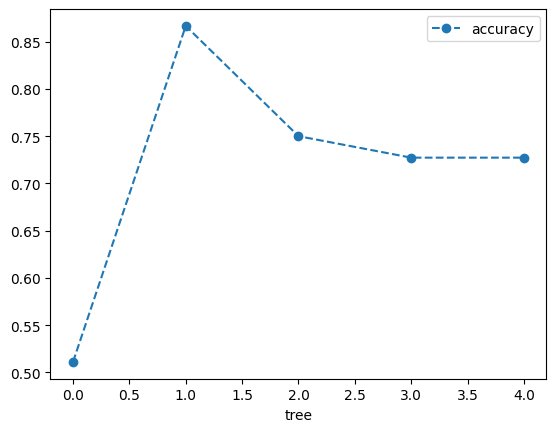

In [27]:
clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=0.016)
scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
dataset = pd.DataFrame(data={'tree': range(5), 'accuracy': scores})

dataset.plot(x='tree', y='accuracy', marker='o', linestyle='--')

So we see that using different **Training** and **Testing** data results in different accuracies.

Now let's use **cross validation** to find the optimal value for `ccp_alpha`.

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

<Figure size 1500x750 with 0 Axes>

<Axes: xlabel='alpha'>

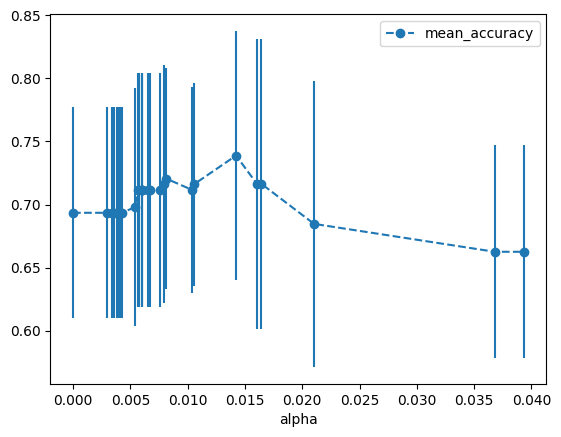

In [28]:
alpha_loop_values = []
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values,
                             columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   yerr='std',
                   marker='o',
                   linestyle='--')

Using cross validation, we can see that, over all, instead of setting `ccp_alpha=0.016`,  we need to set it to something closer to **0.014**. We can find the exact value with:

In [29]:
alpha_results [(alpha_results['alpha'] > 0.014)
              &
              (alpha_results['alpha'] < 0.015)]

,alpha,mean_accuracy,std
21,0.014225,0.738788,0.098832


Now let's store the ideal value for alpha so that we can use it to build the best tree.

In [30]:
ideal_ccp_alpha = alpha_results[(alpha_results['alpha'] > 0.014)
                               &
                               (alpha_results['alpha'] < 0.015)]['alpha']
ideal_ccp_alpha

21    0.014225
Name: alpha, dtype: float64

**NOTE** At this point Python thinks that `ideal_ccp_alpha` is a `series`. We can tell because when we printed `ideal_ccp_alpha` out, we got two bits of stuff. The first one was `20`, which is the index in the series, the second one, `0.014225`, is the value we want. So we can convert this from a series to a float with the following command:

In [31]:
ideal_ccp_alpha = float(ideal_ccp_alpha)
ideal_ccp_alpha

0.014224751066856332

Hooray!!! Now we have the ideal value for `alpha` and we can build, evaluate and draw the final **Classification Tree**.

----

<a id="draw-tree"></a>
# Step 10: Building, Evaluating, Drawing, and Interpreting the Final Classification Tree

Now that we have the ideal value for `alpha` we can build the final **Classification Tree** by setting `ccp_alpha`:

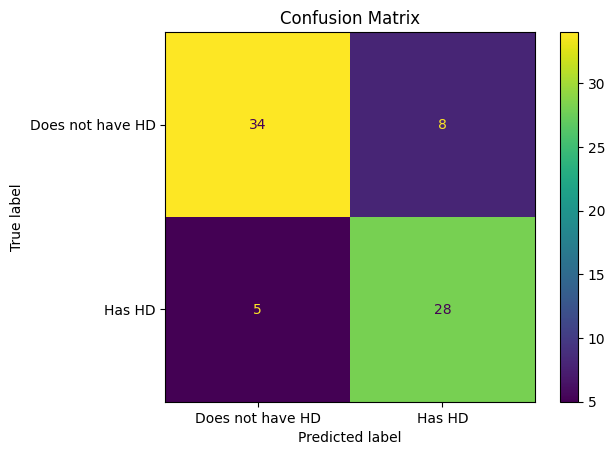

In [32]:
clf_dt_pruned = DecisionTreeClassifier(random_state=42,
                                       ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

y_pred_updated = clf_dt_pruned.predict(X_test)

# Generating Confusion Matrix
cm_updated = confusion_matrix(y_test, y_pred_updated)

# Using ConfusionMatrixDisplay with updated request
disp_updated = ConfusionMatrixDisplay(confusion_matrix=cm_updated, display_labels=["Does not have HD", "Has HD"])
disp_updated.plot()
plt.title('Confusion Matrix')
plt.show()

Hooray!!! We see that the pruned tree is better at classifying patients than the full sized tree.

Of the **34 + 8 = 42** people that did not have heart disease, **34 (81%)** were correctly classified. This is a big improvement over the full sized tree, which only correctly classified **25 (59%)** of the patients without heart disease. Of the **5 + 28 = 33** people with heart disease, **28 (85%)** were correctly classified. Again, this is an improvement over the full sized tree, which only correctly classified **24 (73%)** of the patients with heart disease. Yay for pruning!

The last thing we are going to do is draw the pruned tree and discuss how to interpret it.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


[1]


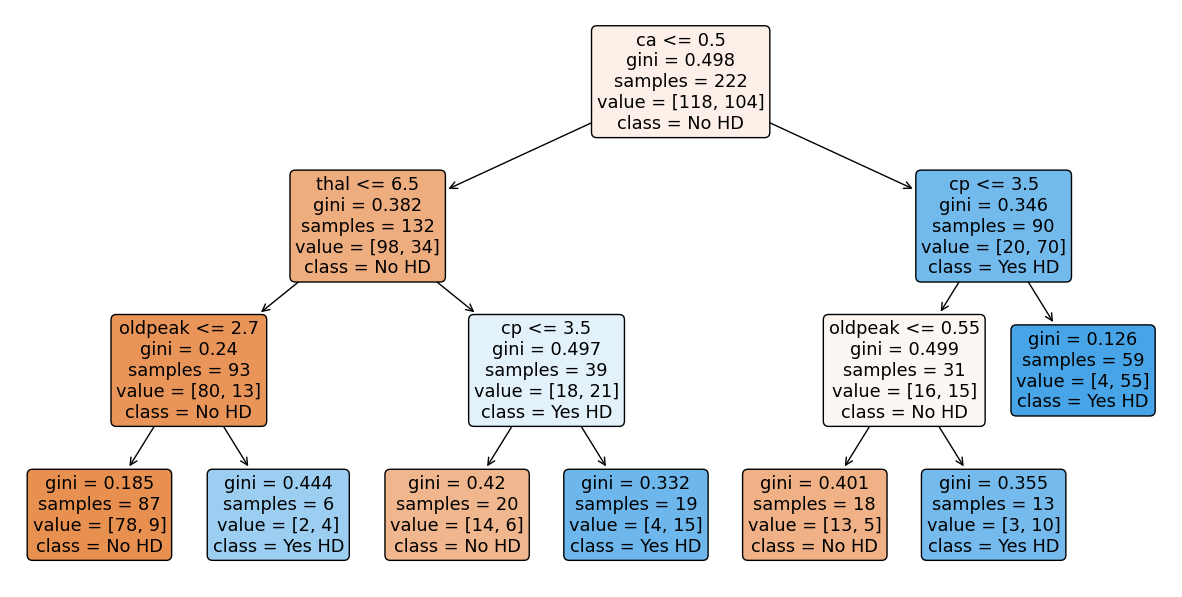

In [33]:
plt.figure(figsize=(15,7.5))
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=["No HD", "Yes HD"],
          feature_names=X.columns)

pred = clf_dt_pruned.predict([[ 63 , 0 , 1, 130, 235 , 0 , 0 , 150, 0 , 1 , 0 , 1 , 1]])
print(pred)

Now let's discuss how to interpret the tree.
In each node, we have:
- The variable (column name) and the threshold for splitting the observations. For example, in the tree's root, we use **ca** to split the observations. All
observations with **ca <= 0.5** go to the **left** and all observations with **ca > 0.5** go to the **right**.
- **gini** is the gini index or score for that node
- **samples** tell us how many samples are in that node
- **value** tells us how many samples in the node are in each category. In this example, we have two categories, **No** and **Yes**, referring to whether or not a patient has heart disease. The number of patients with **No** comes first because the categories are in alphabetical order. Thus, in the root, 118 patients have **No** and 104 patients have **Yes**.
- **class** tells us whichever category is represented most in the node. In the root, since 118 people have **No** and only 104 people have **Yes**, class is set to **No**.

The leaves are just like the nodes, except that they do not contain a variable and threshold for splitting the observations.

The nodes and leaves are colored by the **class**. In this case **No** is different shades of orange-ish and **Yes** is different shades of blue. The the darker the shade, the lower the **gini** score, and that tells us how much the node or leaf is skewed towards one class.

-----